# Predicting Snow Water Equivalent in regions in Western United States


**Estimating snow water equivalent (SWE) at a high spatiotemporal resolution over the Western U.S. using near real-time data sources**

**Author**: Hanis Zulmuthi

May 2022

![http://url/to/img.png](https://i.pinimg.com/originals/9d/d6/5f/9dd65ffbb09b6bb44e5cbb47df654fd3.jpg)
Source: [Reddit.com](https://www.reddit.com/r/EarthPorn/comments/a6ewla/snow_and_flowing_water_is_one_of_the_most_magical/?utm_source=ifttt)

## Overview

This project budded from a competition titled [Snowcast Showdown](https://www.drivendata.org/competitions/90/competition-reclamation-snow-water-eval/page/431/) on [Driven Data](https://www.drivendata.org/). The goal of the project is to develop a predictive model to estimate the distribution of Snow Water Equivalent (SWE)  at a high spatiotemporal resolution over the Western U.S. This predictive model will assist NOAA in their [National Integrated Drought Information System (NIDIS)](https://www.drought.gov/), an initiative to monitor snow drought in the wester United States. 

## Introduction

Snow Water Equivalent (SWE) is a common snowpack measurement used by hydrologists and water managers to gage amount of liquid water contained within snowpack. It is equal to the amount of water contained within the snowpack when it melts. It can be thought of as the depth of water that would theoretically result if you melted the entire snowpack instantaneously [[1]](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/nv/snow/?cid=nrcseprd1746821#:~:text=Snow%20Water%20Equivalent%20(SWE)%20is,the%20snowpack%20when%20it%20melts.).  

Water in a snow pack is determined by depth, density, type of snow, changes in the pack, previous freeze/thaw cycles, recent rainfall events, etc.  Available water is the amount of water that would be released if the snow pack melted.  SWE is an important measure of availability of water resources, since it relates to the runoff of rivers and variations in groundwater levels, so knowing how much water is available in the snow pack is valuable for those managing reservoirs and flood forecasting [[2]](https://www.campbellsci.ca/snow-water-equivalent-measurement)[[3]](http://www.eumetrain.org/data/3/358/navmenu.php?tab=7&page=1.0.0#:~:text=Climatology%20of%20snow%20cover%20and%20snow%20water%20equivalent,-Table%20of%20Contents&text=SWE%20is%20an%20important%20measure,the%20age%20of%20snow%20cover.).

[Reports](https://www.drought.gov/drought-status-updates/water-year-2021-snow-drought-conditions-summary-and-impacts-west) by NOAA (through their [National Integrated Drought Information System (NIDIS)](https://www.drought.gov/) program) on the intensifying snow drought over western U.S raises the alarm on the importance of predicting SWE as accurately possible, especially for remote, high elevation areas where manual ground measure measurements are not feasible. It was reported that the loww snowpack, rapid and early snow melts and poor runoffs had resulted in a significant drop in water supply in the summer of 2021 (fig 1).

![water-reservoir](../figures/reservoir-storage-may-1-2021.jpeg)

Source: [NIDIS, Drought.gov](https://www.drought.gov/drought-status-updates/water-year-2021-snow-drought-conditions-summary-and-impacts-west)


## Data Understanding


**Historical Ground Measures data:** Ground measures help provide regularly collected, highly accurate point estimates of SWE at designated stations. Ground measures data range from 2013-2019 and 2020-2021 was provided in [ground_measures_train_features.csv](./data/ground_measures_train_features.csv) and [ground_measures_test_features.csv](./data/ground_measures_test_features.csv). The ground measures data are from [Snow Telemetry (SNOTEL)](https://www.nrcs.usda.gov/wps/portal/wcc/home/) and [California Data Exchange Center (CDEC)](https://cdec.water.ca.gov/). The dataset used from these sources is available in this repo [here](./data/).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;***[SNOTEL](https://www.nrcs.usda.gov/wps/portal/wcc/home/):*** The Snow Telemetry (SNOTEL) program consists of automated and semi-automated data collection sites across the Western U.S.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;***[CDEC](https://cdec.water.ca.gov/):*** The California Data Exchange Center (CDEC) facilitates the collection, storage, and exchange of hydrologic and climate information to support real-time flood management and water supply needs in California. CDEC operates data collection sites similar to SNOTEL within California.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ground-based sites from SNOTEL and CDEC are used both as an input data source and in ground truth labels for our predictive model. ***Note that, sites that we are predicting SWE for, are entirely distinct from those in the features data.***

**[MODIS Satellite Imagery](https://microsoft.github.io/AIforEarthDataSets/data/modis.html):** The MODIS satellite images consist of MODIS/Terra and MODIS/Aqua Snow Cover Daily L3 Global 500m SIN Grid. Terra's orbit around the Earth is timed so that it passes from north to south across the equator in the morning, while Aqua passes south to north over the equator in the afternoon. Snow-covered land typically has very high reflectance in visible bands and very low reflectance in shortwave infrared bands. The Normalized Difference Snow Index (NDSI) reveals the magnitude of this difference. The snow cover algorithm calculates NDSI for all land and inland water pixels in daylight using MODIS band 4 (visible green) and band 6 (shortwave near-infrared).

The satellite imageries from MODIS were not used for modelling due to contraints in computing power and memory. We did however, pull down the satellite images from their [Azure blob]() and saved it as numpy arrays of pixels. This process was done in this [notebook](./src/MODIS-DEM-Preprocessing_colab.ipynb) that was executed in [Google Colab](https://colab.research.google.com/?utm_source=scs-index).


## Note

Please ensure that you are running this notebook with the correct [conda environment](../geo_env.yml) provided in the project's repo. Run the following lines in your command prompt to activate the environment using the .yml file provided. Ensure that you are in the correct directory in your command prompt before executing the lines below.

```
conda env create -f geo_env.yml
conda activate geo_env

```

Before we begin, let's first import our packages to run this notebook. 

## Import packages

In [135]:
import pandas as pd
pd.set_option('display.max_columns', None)


import numpy as np
import math
import pickle
import folium
import json

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from xgboost import XGBClassifier


from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from catboost import Pool, CatBoostRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

# Modeling

### Load Data

The data we are using for our modeling are cleaned and processed in our [Data Processing notebook](./Data-Preprocessing-EDA(02).ipynb). This final dataframe is also readily available in the repo [here](../data/train_labels_final.csv).

In [5]:
#Load train data

df_train = pd.read_csv('../data/train_labels_final.csv')
df_train = df_train.drop('Unnamed: 0',axis=1)
df_train

,cell_id,dates,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,neighbor_8,neighbor_9,neighbor_10,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20,latitude,longitude,region
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,2.0,1.6,6.4,3.2,2.7,2.0,2.8,NaN,3.7,1.6,3.9,4.3,5.9,6.6,10.60,8.4,2.88,4.10,7.24,4.00,-121.9,41.2,other
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,2.0,1.6,6.4,3.2,2.7,2.0,2.8,NaN,3.7,1.6,3.9,4.3,5.9,10.6,6.60,8.4,2.88,4.10,7.24,4.00,-120.6,39.7,sierras
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0,2.0,1.6,6.4,3.2,2.7,2.0,2.8,NaN,3.7,1.6,3.9,4.3,5.9,10.6,6.60,8.4,2.88,7.24,4.10,4.00,-119.6,38.3,sierras
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3,2.0,1.6,3.2,6.4,2.7,2.0,2.8,6.6,3.7,1.6,NaN,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,7.20,-107.2,44.6,other
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0,2.0,1.6,3.2,6.4,2.7,2.0,2.8,6.6,3.7,NaN,1.6,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,10.60,-106.6,40.4,central rockies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50453,fd4492f2-8aa9-4279-bdc0-73991786943f,2019-12-31,1.3,1.3,2.7,6.7,4.0,2.1,1.5,2.8,4.1,6.1,7.1,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93,-105.1,38.9,central rockies
50454,fde3221a-9ce3-45a9-857f-bd196b07aa05,2019-12-31,5.6,1.3,2.7,6.7,4.0,2.1,1.5,2.8,4.1,6.1,7.1,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93,-106.1,39.3,central rockies
50455,fdeb8912-f9d1-445d-aadb-e943534f67fe,2019-12-31,8.8,1.3,2.7,6.7,4.0,2.1,1.5,2.8,6.1,7.1,1.3,4.1,3.9,5.5,9.9,5.30,6.9,3.70,9.93,3.90,1.50,-107.9,37.8,central rockies
50456,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2019-12-31,2.9,1.3,2.7,4.0,6.7,2.1,1.5,2.8,7.1,6.1,1.3,3.9,5.5,9.9,4.1,9.93,5.3,10.92,6.90,3.70,6.00,-122.0,43.9,other


In [6]:
#Make sure our data types is correct
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50458 entries, 0 to 50457
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cell_id      50458 non-null  object 
 1   dates        50458 non-null  object 
 2   value        50458 non-null  float64
 3   neighbor_1   50458 non-null  float64
 4   neighbor_2   50458 non-null  float64
 5   neighbor_3   50458 non-null  float64
 6   neighbor_4   50458 non-null  float64
 7   neighbor_5   50458 non-null  float64
 8   neighbor_6   50458 non-null  float64
 9   neighbor_7   50458 non-null  float64
 10  neighbor_8   42424 non-null  float64
 11  neighbor_9   43759 non-null  float64
 12  neighbor_10  47152 non-null  float64
 13  neighbor_11  49849 non-null  float64
 14  neighbor_12  50458 non-null  float64
 15  neighbor_13  50458 non-null  float64
 16  neighbor_14  50458 non-null  float64
 17  neighbor_15  50458 non-null  float64
 18  neighbor_16  50458 non-null  float64
 19  neig

The below nulls were intentionally left untouched in the data processing, as these nulls will benefit more from being imputed within our modeling workflow.

In [7]:
df_train.isna().sum()/len(df_train)

cell_id        0.000000
dates          0.000000
value          0.000000
neighbor_1     0.000000
neighbor_2     0.000000
neighbor_3     0.000000
neighbor_4     0.000000
neighbor_5     0.000000
neighbor_6     0.000000
neighbor_7     0.000000
neighbor_8     0.159222
neighbor_9     0.132764
neighbor_10    0.065520
neighbor_11    0.012069
neighbor_12    0.000000
neighbor_13    0.000000
neighbor_14    0.000000
neighbor_15    0.000000
neighbor_16    0.000000
neighbor_17    0.000000
neighbor_18    0.000000
neighbor_19    0.000000
neighbor_20    0.000000
latitude       0.000000
longitude      0.000000
region         0.000000
dtype: float64

In [132]:
# Load test data

df_test = pd.read_csv('../data/test_labels_final.csv')
df_test = df_test.drop('Unnamed: 0',axis=1)
df_test

,cell_id,dates,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,neighbor_8,neighbor_9,neighbor_10,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20,latitude,longitude,region
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2020-01-07,8.0,1.2,2.8,3.7,6.7,2.1,1.6,2.8,7.2,6.1,1.5,3.9,5.2,10.0,3.50,10.06,10.68,6.60,5.10,7.53,6.90,-121.9,41.2,other
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2020-01-07,11.4,1.2,2.8,3.7,6.7,2.1,1.6,2.8,7.2,6.1,1.5,3.9,5.2,10.0,10.06,3.50,10.68,6.60,5.10,7.53,6.90,-120.6,39.7,sierras
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2020-01-07,18.5,1.2,2.8,3.7,6.7,2.1,1.6,2.8,7.2,6.1,1.5,3.9,5.2,10.0,10.06,3.50,10.68,6.60,7.53,5.10,6.90,-119.6,38.3,sierras
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2020-01-07,3.9,1.2,2.8,6.7,3.7,2.1,1.6,2.8,3.5,6.1,1.5,7.2,3.9,5.2,10.00,5.10,6.90,3.50,3.70,1.40,14.10,-107.2,44.6,other
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2020-01-07,13.0,1.2,2.8,6.7,3.7,2.1,1.6,2.8,3.5,6.1,7.2,1.5,3.9,5.2,10.00,5.10,6.90,3.50,3.70,1.40,10.06,-106.6,40.4,central rockies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45236,fd4492f2-8aa9-4279-bdc0-73991786943f,2021-06-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.31,-105.1,38.9,central rockies
45237,fde3221a-9ce3-45a9-857f-bd196b07aa05,2021-06-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.31,-106.1,39.3,central rockies
45238,fdeb8912-f9d1-445d-aadb-e943534f67fe,2021-06-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.31,0.00,0.00,-107.9,37.8,central rockies
45239,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2021-06-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.31,0.00,1.68,0.00,0.00,0.36,-122.0,43.9,other


## Train-test-split

Let's split our dataframes into X_train, y_train, _test and y_test.

In [133]:
X_train = df_train.drop(['cell_id','dates','value'],axis=1)
y_train = df_train['value']
X_test = df_test.drop(['cell_id','dates','value'],axis=1)
y_test = df_test['value']


## Modeling EDA

Let's find out the correlation between our model features to ensure we are handling multicollinearity accordingly.

<AxesSubplot:>

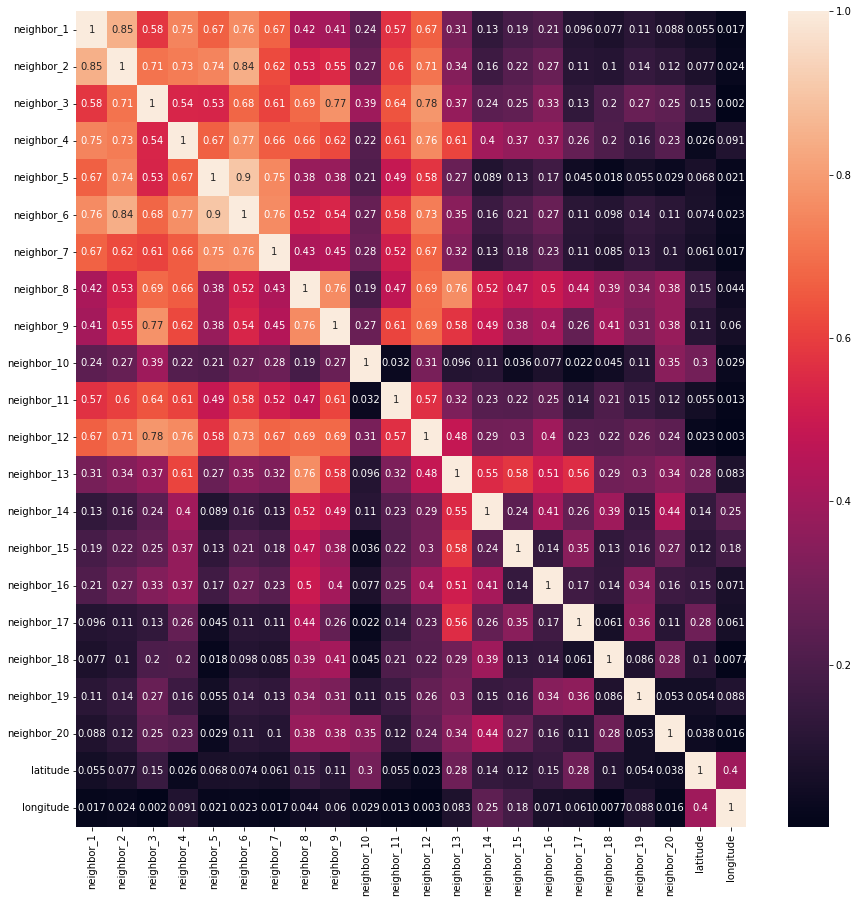

In [9]:
fig, ax = plt.subplots(figsize = (15,15))

sns.heatmap(abs(X_train.corr()),annot=True, ax=ax)

It seems like our top 13 nearest neighbors of ground measured stations are highly correlated. This is possibly because top 13 nearest stations to the grid cell is also near to each other in distance and therefore, the SWE values of the top 13 nearest neighbors are correlated to each other by distance. To reduce the multicollinearity between these stations, we can perform PCA on the first 13 neighbors as part of our pipeline.

## Modeling Building

We are going to begin our model testing with our training data. We will be using pipelines functions, and Function transformers to smooth our model building process and ensure no data leakage takes place in our workflow.

### Functions

In [10]:
def grab_numeric(df):
    
    """
    Helper function to grab only numeric columns from our dataframe.
    """
    return df.select_dtypes(include=['float', 'int'])

In [11]:
def grab_object(df):
    
    """
    Helper function to grab only categorical columns from our dataframe.
    """
    
    return df.select_dtypes(include=['object'])

In [12]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} R_squared
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

#### Testing functions

In [15]:
#Sniff test, ensuring function outputs what we want

num_df=grab_numeric(df_train)
num_df

,value,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_6,neighbor_7,neighbor_8,neighbor_9,neighbor_10,neighbor_11,neighbor_12,neighbor_13,neighbor_14,neighbor_15,neighbor_16,neighbor_17,neighbor_18,neighbor_19,neighbor_20,latitude,longitude
0,12.7,2.0,1.6,6.4,3.2,2.7,2.0,2.8,NaN,3.7,1.6,3.9,4.3,5.9,6.6,10.60,8.4,2.88,4.10,7.24,4.00,-121.9,41.2
1,20.4,2.0,1.6,6.4,3.2,2.7,2.0,2.8,NaN,3.7,1.6,3.9,4.3,5.9,10.6,6.60,8.4,2.88,4.10,7.24,4.00,-120.6,39.7
2,37.0,2.0,1.6,6.4,3.2,2.7,2.0,2.8,NaN,3.7,1.6,3.9,4.3,5.9,10.6,6.60,8.4,2.88,7.24,4.10,4.00,-119.6,38.3
3,2.3,2.0,1.6,3.2,6.4,2.7,2.0,2.8,6.6,3.7,1.6,NaN,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,7.20,-107.2,44.6
4,8.0,2.0,1.6,3.2,6.4,2.7,2.0,2.8,6.6,3.7,NaN,1.6,3.9,4.3,5.9,4.10,4.0,3.40,2.60,2.30,10.60,-106.6,40.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50453,1.3,1.3,2.7,6.7,4.0,2.1,1.5,2.8,4.1,6.1,7.1,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93,-105.1,38.9
50454,5.6,1.3,2.7,6.7,4.0,2.1,1.5,2.8,4.1,6.1,7.1,1.3,3.9,5.5,9.9,5.30,6.9,3.70,3.90,1.50,9.93,-106.1,39.3
50455,8.8,1.3,2.7,6.7,4.0,2.1,1.5,2.8,6.1,7.1,1.3,4.1,3.9,5.5,9.9,5.30,6.9,3.70,9.93,3.90,1.50,-107.9,37.8
50456,2.9,1.3,2.7,4.0,6.7,2.1,1.5,2.8,7.1,6.1,1.3,3.9,5.5,9.9,4.1,9.93,5.3,10.92,6.90,3.70,6.00,-122.0,43.9


In [16]:
#Sniff test, ensuring function outputs what we want

cat_df = grab_object(df_train)
cat_df.head()

,cell_id,dates,region
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,other
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,sierras
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,sierras
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,other
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,central rockies


#### Building function transformers

In [17]:
GrabNumeric = FunctionTransformer(grab_numeric)
GrabObject = FunctionTransformer(grab_object)

### Building `subpipelines` and `Column Transformer`

We'll create Column Transformers that will scale our features, one hot encode our categorical features and pca the first 13 columns which are our top 13 nearest ground stations.

In [46]:
# We'll throw these mini-pipelines into our ColumnTransformer: numeric and categorical, then PCA

#subpipe that handles our numerical columns
subpipe_num= Pipeline(steps=[('get_num', GrabNumeric),
                              ('ss', StandardScaler()),
                              ('num_impute', IterativeImputer(estimator=RandomForestRegressor(
                                                                                            n_estimators=4,
                                                                                            max_depth=10,
                                                                                            bootstrap=True,
                                                                                            max_samples=0.5,
                                                                                            n_jobs=2,
                                                                                            random_state=0),
                                                              skip_complete=True,
                                                              random_state=250))
                             
                             ])

#Subpipe that handles our categorical columns 
subpipe_cat = Pipeline(steps=[('get_obj', GrabObject),
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
                              ])

#Subpipe that PCA our numerical columns 
subpipe_pca = Pipeline(steps= [('PCA', PCA(n_components=3)),
                              ('ss_pca', StandardScaler()),
                              ])

`subpipe_pca`is our attempt to handle multicollinearity between the features that are highly correlated which are our first 13 columns. So, only the first 13 columns will be put through `subpipe_pca`. 

In [47]:
#First column transformer 
ct_all = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, X_train.columns),
    ('subpipe_cat', subpipe_cat, X_train.columns)
])

#Column transformer that will perform PCA on our first 13 columns
ct_pca = ColumnTransformer(transformers=[
                                        ('subpipe_pca', subpipe_pca, list(range(0,13)))
                                        ], remainder='passthrough')

Let's run our column transformers here to make sure that they run as expected.

In [21]:
#Test out our first column transformer
ct_test_df = pd.DataFrame(ct_all.fit_transform(X_train.head(20)))
ct_test_final_df = pd.DataFrame(ct_pca.fit_transform(ct_test_df))
ct_test_final_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.921960,-0.251102,0.079468,0.064701,1.916289,1.309390,-0.705142,-0.376977,0.809579,-0.274829,-1.572454,-0.156705,0.0,1.0,0.0
1,1.921960,-0.251102,0.079468,2.940316,0.367773,1.309390,-0.705142,-0.376977,0.809579,-0.274829,-1.308857,-0.584084,0.0,0.0,1.0
2,1.921960,-0.251102,0.079468,2.940316,0.367773,1.309390,-0.705142,0.599680,-0.250946,-0.274829,-1.106091,-0.982970,0.0,0.0,1.0
3,-0.422931,0.295684,0.032387,-0.438531,-0.600050,-0.570321,-0.477677,-0.843533,-0.858890,0.770894,1.408213,0.812019,0.0,1.0,0.0
4,-0.194933,1.849411,0.401084,-0.438531,-0.600050,-0.570321,-0.477677,-0.843533,-0.858890,1.881976,1.529873,-0.384640,1.0,0.0,0.0
5,-0.709649,-0.830870,0.431433,-0.438531,-0.600050,-0.570321,-0.477677,-0.843533,1.944408,-0.830370,0.455211,0.925986,0.0,1.0,0.0
6,-0.709649,-0.830870,0.431433,-0.438531,-0.600050,-0.570321,-0.477677,1.644765,-0.757566,-0.830370,1.347383,-1.210905,1.0,0.0,0.0
7,-0.709649,-0.830870,0.431433,-0.438531,-0.600050,-0.570321,-0.477677,1.644765,-0.757566,-0.830370,1.306830,-1.096937,1.0,0.0,0.0
8,0.234955,0.148202,-0.094996,0.064701,1.916289,-0.527601,1.709487,-0.408081,-0.487368,-0.640833,-0.376132,-0.669559,0.0,1.0,0.0
9,-0.709649,-0.830870,0.431433,-0.438531,-0.600050,-0.570321,-0.477677,1.644765,-0.757566,-0.830370,0.657977,-0.270673,0.0,1.0,0.0


Yay! It performed as expected! Now, let's check for correlation between our features again.

<AxesSubplot:>

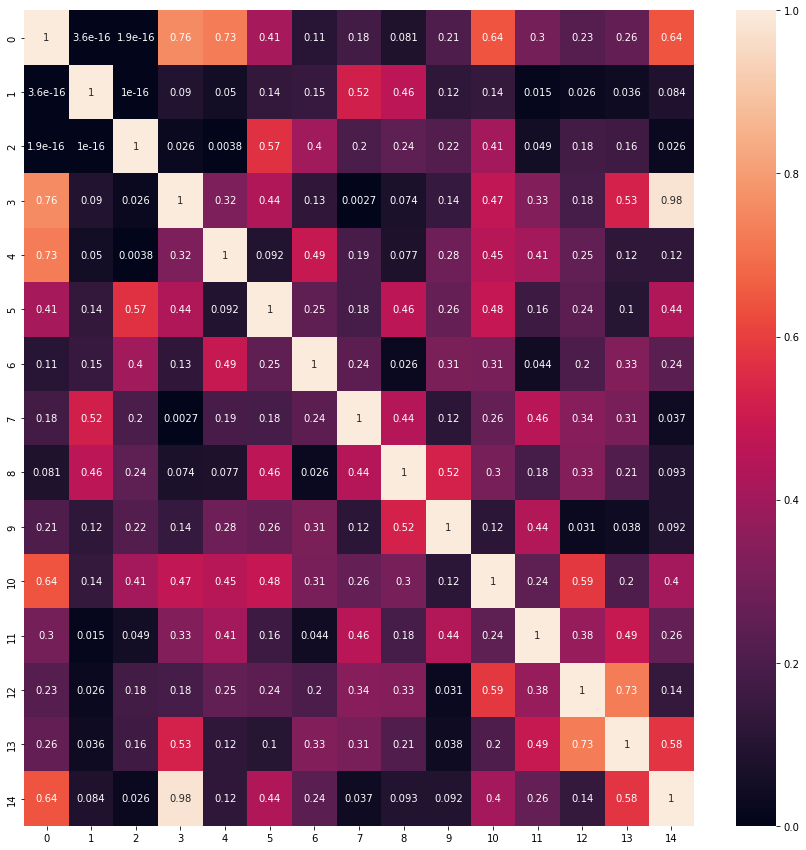

In [22]:
fig, ax = plt.subplots(figsize = (15,15))

sns.heatmap(abs(ct_test_final_df.corr()),annot=True, ax=ax)

The correlation heatmap between our features are looking much better now. However, correlation between column 4 and 14 changed to be more than 0.7. We'll leave this as is.

### Dummy Model

Let's build our first simple model using [Dummy Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) from sklearn.

In [74]:
#Build a dummy model pipeline

dummy_model_pipe = Pipeline(steps=[
    ('ct1',ct_all),
    ('ct2', ct_pca),
    ('dummy_mod',DummyRegressor())
])

dummy_modelCV = ModelWithCV(dummy_model_pipe,model_name = 'dummy_mod', X=X_train,y=y_train)

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [76]:
dummy_modelCV.print_cv_summary()

CV Results for `dummy_mod` model:
            -0.09730 ± 0.16507 R_squared
        


The R2 for our dummy model is -0.0973. That's....pretty low. So, our other models should beat our Dummy Model's R2 which is a pretty low bar.

### Linear Regression

Let's see if a simple Linear Regression can beat our R2 of our First simple model

In [72]:
linreg_pipe = Pipeline(steps=[
    ('ct1',ct_all),
    ('ct2', ct_pca),
    ('linreg',LinearRegression()) 
])
    
linreg_CV = ModelWithCV(linreg_pipe,model_name = 'linreg', X=X_train,y=y_train)

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [73]:
linreg_CV.print_cv_summary()

CV Results for `linreg` model:
            0.16237 ± 0.08352 R_squared
        


That's definitely way better than our Dummy Model! We ran our Linear Regression on default and it did better than our first simple model but still pretty bad R2. Let's try gradient boosting models to see if it'ss provide us with better R2.

### GradientBoostingRegressor

[Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html?highlight=gradient%20boosting#sklearn.ensemble.GradientBoostingRegressor) from sklearn is an ensemble of gradient boosting models; CatBoost + XGBoost and LightGBM. 

In [77]:
GBR_model_pipe = Pipeline(steps=[
    ('ct1',ct_all),
    ('ct2', ct_pca),
    ('GBR',GradientBoostingRegressor(random_state=42))
])

GBR_pipe = ModelWithCV(GBR_model_pipe,model_name = 'GBR', X=X_train,y=y_train)

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [78]:
GBR_pipe.print_cv_summary()

CV Results for `GBR` model:
            0.17293 ± 0.36045 R_squared
        


Our Gradient Boosting regressor on default parameters have slight improvement from our Linear Regression. Before we spend computational time and memory to grid search this model, let's test how CatBoost Regressor and LightGBM on its own.

### Catboost Regressor

In [90]:
catboost_model_pipe = Pipeline(steps=[
    ('ct1',ct_all),
    ('ct2', ct_pca),
    ('catboost',CatBoostRegressor(random_seed=42))
])

catboost_model = catboost_model_pipe.fit(X_train,y_train)

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Learning rate set to 0.076075
0:	learn: 12.4557434	total: 12.3ms	remaining: 12.3s
1:	learn: 12.2195065	total: 23.9ms	remaining: 11.9s
2:	learn: 12.0278891	total: 34.6ms	remaining: 11.5s
3:	learn: 11.8555841	total: 44.7ms	remaining: 11.1s
4:	learn: 11.6927678	total: 52.8ms	remaining: 10.5s
5:	learn: 11.5300362	total: 61.6ms	remaining: 10.2s
6:	learn: 11.3942079	total: 69.9ms	remaining: 9.91s
7:	learn: 11.2702913	total: 79.3ms	remaining: 9.83s
8:	learn: 11.1522792	total: 88ms	remaining: 9.69s
9:	learn: 11.0529175	total: 94.9ms	remaining: 9.39s
10:	learn: 10.9567380	total: 101ms	remaining: 9.06s
11:	learn: 10.8650715	total: 109ms	remaining: 9s
12:	learn: 10.7839164	total: 117ms	remaining: 8.85s
13:	learn: 10.7069648	total: 124ms	remaining: 8.71s
14:	learn: 10.6331123	total: 130ms	remaining: 8.51s
15:	learn: 10.5571169	total: 136ms	remaining: 8.36s
16:	learn: 10.4870041	total: 145ms	remaining: 8.38s
17:	learn: 10.4224227	total: 152ms	remaining: 8.29s
18:	learn: 10.3646959	total: 158ms	rema

180:	learn: 7.8849511	total: 1.44s	remaining: 6.53s
181:	learn: 7.8790640	total: 1.45s	remaining: 6.52s
182:	learn: 7.8776206	total: 1.46s	remaining: 6.51s
183:	learn: 7.8674758	total: 1.47s	remaining: 6.5s
184:	learn: 7.8599905	total: 1.47s	remaining: 6.5s
185:	learn: 7.8541842	total: 1.48s	remaining: 6.5s
186:	learn: 7.8434446	total: 1.5s	remaining: 6.5s
187:	learn: 7.8342581	total: 1.5s	remaining: 6.49s
188:	learn: 7.8279764	total: 1.51s	remaining: 6.48s
189:	learn: 7.8236282	total: 1.52s	remaining: 6.47s
190:	learn: 7.8115560	total: 1.52s	remaining: 6.46s
191:	learn: 7.8075580	total: 1.53s	remaining: 6.45s
192:	learn: 7.8014184	total: 1.54s	remaining: 6.43s
193:	learn: 7.7955984	total: 1.55s	remaining: 6.43s
194:	learn: 7.7918281	total: 1.55s	remaining: 6.42s
195:	learn: 7.7879206	total: 1.56s	remaining: 6.41s
196:	learn: 7.7827264	total: 1.57s	remaining: 6.39s
197:	learn: 7.7770086	total: 1.57s	remaining: 6.38s
198:	learn: 7.7700334	total: 1.58s	remaining: 6.37s
199:	learn: 7.7651

356:	learn: 7.1079443	total: 3.12s	remaining: 5.62s
357:	learn: 7.1057253	total: 3.13s	remaining: 5.62s
358:	learn: 7.1037969	total: 3.16s	remaining: 5.64s
359:	learn: 7.1009451	total: 3.17s	remaining: 5.63s
360:	learn: 7.0975311	total: 3.18s	remaining: 5.63s
361:	learn: 7.0954099	total: 3.19s	remaining: 5.62s
362:	learn: 7.0939507	total: 3.2s	remaining: 5.62s
363:	learn: 7.0906708	total: 3.21s	remaining: 5.61s
364:	learn: 7.0893195	total: 3.22s	remaining: 5.61s
365:	learn: 7.0873835	total: 3.23s	remaining: 5.6s
366:	learn: 7.0836564	total: 3.25s	remaining: 5.6s
367:	learn: 7.0803386	total: 3.25s	remaining: 5.59s
368:	learn: 7.0753780	total: 3.27s	remaining: 5.59s
369:	learn: 7.0725181	total: 3.28s	remaining: 5.58s
370:	learn: 7.0708152	total: 3.29s	remaining: 5.58s
371:	learn: 7.0671054	total: 3.3s	remaining: 5.57s
372:	learn: 7.0646364	total: 3.31s	remaining: 5.57s
373:	learn: 7.0601596	total: 3.32s	remaining: 5.56s
374:	learn: 7.0559138	total: 3.34s	remaining: 5.56s
375:	learn: 7.05

520:	learn: 6.7273333	total: 5.03s	remaining: 4.63s
521:	learn: 6.7262543	total: 5.05s	remaining: 4.62s
522:	learn: 6.7244281	total: 5.06s	remaining: 4.62s
523:	learn: 6.7223453	total: 5.08s	remaining: 4.61s
524:	learn: 6.7209412	total: 5.09s	remaining: 4.6s
525:	learn: 6.7195894	total: 5.1s	remaining: 4.6s
526:	learn: 6.7181143	total: 5.11s	remaining: 4.59s
527:	learn: 6.7168077	total: 5.13s	remaining: 4.58s
528:	learn: 6.7147448	total: 5.14s	remaining: 4.57s
529:	learn: 6.7133389	total: 5.15s	remaining: 4.57s
530:	learn: 6.7124070	total: 5.16s	remaining: 4.56s
531:	learn: 6.7109324	total: 5.17s	remaining: 4.55s
532:	learn: 6.7095620	total: 5.18s	remaining: 4.54s
533:	learn: 6.7068280	total: 5.19s	remaining: 4.53s
534:	learn: 6.7056697	total: 5.21s	remaining: 4.52s
535:	learn: 6.7042996	total: 5.22s	remaining: 4.52s
536:	learn: 6.7029526	total: 5.23s	remaining: 4.51s
537:	learn: 6.6995144	total: 5.24s	remaining: 4.5s
538:	learn: 6.6975915	total: 5.25s	remaining: 4.49s
539:	learn: 6.69

685:	learn: 6.4524771	total: 6.92s	remaining: 3.17s
686:	learn: 6.4509519	total: 6.93s	remaining: 3.16s
687:	learn: 6.4499209	total: 6.95s	remaining: 3.15s
688:	learn: 6.4485109	total: 6.96s	remaining: 3.14s
689:	learn: 6.4473200	total: 6.97s	remaining: 3.13s
690:	learn: 6.4460693	total: 6.98s	remaining: 3.12s
691:	learn: 6.4452557	total: 6.99s	remaining: 3.11s
692:	learn: 6.4440758	total: 7s	remaining: 3.1s
693:	learn: 6.4428023	total: 7.01s	remaining: 3.09s
694:	learn: 6.4413955	total: 7.02s	remaining: 3.08s
695:	learn: 6.4400521	total: 7.03s	remaining: 3.07s
696:	learn: 6.4384775	total: 7.04s	remaining: 3.06s
697:	learn: 6.4370252	total: 7.05s	remaining: 3.05s
698:	learn: 6.4348820	total: 7.07s	remaining: 3.04s
699:	learn: 6.4338793	total: 7.08s	remaining: 3.03s
700:	learn: 6.4319687	total: 7.09s	remaining: 3.02s
701:	learn: 6.4307258	total: 7.1s	remaining: 3.01s
702:	learn: 6.4299180	total: 7.12s	remaining: 3.01s
703:	learn: 6.4278259	total: 7.13s	remaining: 3s
704:	learn: 6.427170

851:	learn: 6.2535723	total: 8.79s	remaining: 1.53s
852:	learn: 6.2520732	total: 8.8s	remaining: 1.52s
853:	learn: 6.2510876	total: 8.81s	remaining: 1.51s
854:	learn: 6.2504784	total: 8.82s	remaining: 1.5s
855:	learn: 6.2495032	total: 8.83s	remaining: 1.49s
856:	learn: 6.2489258	total: 8.85s	remaining: 1.48s
857:	learn: 6.2474884	total: 8.86s	remaining: 1.47s
858:	learn: 6.2455349	total: 8.87s	remaining: 1.46s
859:	learn: 6.2438640	total: 8.88s	remaining: 1.45s
860:	learn: 6.2432085	total: 8.89s	remaining: 1.43s
861:	learn: 6.2427784	total: 8.9s	remaining: 1.42s
862:	learn: 6.2415891	total: 8.91s	remaining: 1.41s
863:	learn: 6.2406909	total: 8.92s	remaining: 1.4s
864:	learn: 6.2401309	total: 8.93s	remaining: 1.39s
865:	learn: 6.2391881	total: 8.94s	remaining: 1.38s
866:	learn: 6.2381874	total: 8.95s	remaining: 1.37s
867:	learn: 6.2379633	total: 8.96s	remaining: 1.36s
868:	learn: 6.2371614	total: 8.97s	remaining: 1.35s
869:	learn: 6.2362793	total: 8.98s	remaining: 1.34s
870:	learn: 6.23

In [80]:
catboost_model = ModelWithCV(catboost_model_pipe,model_name = 'catboost', X=X_train,y=y_train)

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Learning rate set to 0.07344
0:	learn: 12.9011616	total: 7.46ms	remaining: 7.46s
1:	learn: 12.6675687	total: 14ms	remaining: 6.98s
2:	learn: 12.4526476	total: 21.3ms	remaining: 7.07s
3:	learn: 12.2711169	total: 27.8ms	remaining: 6.92s
4:	learn: 12.0910767	total: 35.4ms	remaining: 7.05s
5:	learn: 11.9363495	total: 43.3ms	remaining: 7.17s
6:	learn: 11.7842784	total: 50.6ms	remaining: 7.17s
7:	learn: 11.6449428	total: 59ms	remaining: 7.32s
8:	learn: 11.5350789	total: 65.6ms	remaining: 7.22s
9:	learn: 11.4211548	total: 74.3ms	remaining: 7.36s
10:	learn: 11.3173309	total: 81.7ms	remaining: 7.34s
11:	learn: 11.2227504	total: 90.3ms	remaining: 7.44s
12:	learn: 11.1185473	total: 97.1ms	remaining: 7.38s
13:	learn: 11.0329780	total: 110ms	remaining: 7.74s
14:	learn: 10.9489837	total: 119ms	remaining: 7.84s
15:	learn: 10.8610063	total: 127ms	remaining: 7.81s
16:	learn: 10.7803513	total: 139ms	remaining: 8.03s
17:	learn: 10.7237153	total: 146ms	remaining: 7.96s
18:	learn: 10.6687079	total: 153ms	r

172:	learn: 8.2714128	total: 2.11s	remaining: 10.1s
173:	learn: 8.2662876	total: 2.13s	remaining: 10.1s
174:	learn: 8.2551084	total: 2.14s	remaining: 10.1s
175:	learn: 8.2476791	total: 2.16s	remaining: 10.1s
176:	learn: 8.2418726	total: 2.18s	remaining: 10.1s
177:	learn: 8.2321478	total: 2.19s	remaining: 10.1s
178:	learn: 8.2245666	total: 2.2s	remaining: 10.1s
179:	learn: 8.2190253	total: 2.22s	remaining: 10.1s
180:	learn: 8.2138495	total: 2.23s	remaining: 10.1s
181:	learn: 8.2080274	total: 2.25s	remaining: 10.1s
182:	learn: 8.1932697	total: 2.26s	remaining: 10.1s
183:	learn: 8.1847866	total: 2.27s	remaining: 10.1s
184:	learn: 8.1791469	total: 2.29s	remaining: 10.1s
185:	learn: 8.1727049	total: 2.29s	remaining: 10s
186:	learn: 8.1614408	total: 2.31s	remaining: 10s
187:	learn: 8.1551724	total: 2.32s	remaining: 10s
188:	learn: 8.1478958	total: 2.33s	remaining: 10s
189:	learn: 8.1417561	total: 2.35s	remaining: 10s
190:	learn: 8.1376446	total: 2.36s	remaining: 10s
191:	learn: 8.1316178	tot

343:	learn: 7.4336188	total: 4.21s	remaining: 8.03s
344:	learn: 7.4309019	total: 4.23s	remaining: 8.03s
345:	learn: 7.4282544	total: 4.24s	remaining: 8.02s
346:	learn: 7.4253140	total: 4.25s	remaining: 8.01s
347:	learn: 7.4160543	total: 4.27s	remaining: 8s
348:	learn: 7.4131550	total: 4.28s	remaining: 7.99s
349:	learn: 7.4109476	total: 4.29s	remaining: 7.97s
350:	learn: 7.4092907	total: 4.3s	remaining: 7.96s
351:	learn: 7.4061615	total: 4.31s	remaining: 7.94s
352:	learn: 7.4037254	total: 4.33s	remaining: 7.93s
353:	learn: 7.4017346	total: 4.34s	remaining: 7.91s
354:	learn: 7.3994366	total: 4.35s	remaining: 7.9s
355:	learn: 7.3957102	total: 4.36s	remaining: 7.89s
356:	learn: 7.3940254	total: 4.37s	remaining: 7.87s
357:	learn: 7.3918526	total: 4.38s	remaining: 7.86s
358:	learn: 7.3892715	total: 4.39s	remaining: 7.84s
359:	learn: 7.3861960	total: 4.4s	remaining: 7.83s
360:	learn: 7.3841242	total: 4.41s	remaining: 7.81s
361:	learn: 7.3804014	total: 4.43s	remaining: 7.8s
362:	learn: 7.37728

512:	learn: 7.0179925	total: 6.56s	remaining: 6.23s
513:	learn: 7.0166678	total: 6.58s	remaining: 6.22s
514:	learn: 7.0155778	total: 6.59s	remaining: 6.21s
515:	learn: 7.0145976	total: 6.6s	remaining: 6.2s
516:	learn: 7.0123661	total: 6.62s	remaining: 6.18s
517:	learn: 7.0092064	total: 6.63s	remaining: 6.17s
518:	learn: 7.0073005	total: 6.65s	remaining: 6.16s
519:	learn: 7.0059433	total: 6.66s	remaining: 6.14s
520:	learn: 7.0045195	total: 6.67s	remaining: 6.13s
521:	learn: 7.0018276	total: 6.68s	remaining: 6.12s
522:	learn: 6.9997817	total: 6.69s	remaining: 6.1s
523:	learn: 6.9980179	total: 6.7s	remaining: 6.09s
524:	learn: 6.9971988	total: 6.71s	remaining: 6.07s
525:	learn: 6.9950973	total: 6.72s	remaining: 6.06s
526:	learn: 6.9932400	total: 6.74s	remaining: 6.05s
527:	learn: 6.9915657	total: 6.75s	remaining: 6.03s
528:	learn: 6.9898180	total: 6.76s	remaining: 6.02s
529:	learn: 6.9883382	total: 6.78s	remaining: 6.01s
530:	learn: 6.9862197	total: 6.79s	remaining: 6s
531:	learn: 6.98437

682:	learn: 6.7417538	total: 8.62s	remaining: 4s
683:	learn: 6.7404050	total: 8.63s	remaining: 3.99s
684:	learn: 6.7388118	total: 8.65s	remaining: 3.98s
685:	learn: 6.7377970	total: 8.66s	remaining: 3.96s
686:	learn: 6.7368666	total: 8.67s	remaining: 3.95s
687:	learn: 6.7356843	total: 8.68s	remaining: 3.94s
688:	learn: 6.7348383	total: 8.7s	remaining: 3.92s
689:	learn: 6.7342394	total: 8.71s	remaining: 3.91s
690:	learn: 6.7330720	total: 8.72s	remaining: 3.9s
691:	learn: 6.7323728	total: 8.73s	remaining: 3.89s
692:	learn: 6.7307303	total: 8.74s	remaining: 3.87s
693:	learn: 6.7298297	total: 8.76s	remaining: 3.86s
694:	learn: 6.7285719	total: 8.77s	remaining: 3.85s
695:	learn: 6.7277489	total: 8.78s	remaining: 3.83s
696:	learn: 6.7262782	total: 8.79s	remaining: 3.82s
697:	learn: 6.7249734	total: 8.8s	remaining: 3.81s
698:	learn: 6.7222787	total: 8.81s	remaining: 3.79s
699:	learn: 6.7210824	total: 8.83s	remaining: 3.78s
700:	learn: 6.7199387	total: 8.84s	remaining: 3.77s
701:	learn: 6.7183

856:	learn: 6.5275922	total: 11s	remaining: 1.83s
857:	learn: 6.5271992	total: 11s	remaining: 1.82s
858:	learn: 6.5262488	total: 11s	remaining: 1.81s
859:	learn: 6.5253094	total: 11s	remaining: 1.79s
860:	learn: 6.5233048	total: 11s	remaining: 1.78s
861:	learn: 6.5224556	total: 11.1s	remaining: 1.77s
862:	learn: 6.5215930	total: 11.1s	remaining: 1.76s
863:	learn: 6.5200889	total: 11.1s	remaining: 1.74s
864:	learn: 6.5192699	total: 11.1s	remaining: 1.73s
865:	learn: 6.5181257	total: 11.1s	remaining: 1.72s
866:	learn: 6.5175439	total: 11.1s	remaining: 1.7s
867:	learn: 6.5165082	total: 11.1s	remaining: 1.69s
868:	learn: 6.5159863	total: 11.1s	remaining: 1.68s
869:	learn: 6.5152907	total: 11.1s	remaining: 1.67s
870:	learn: 6.5130755	total: 11.2s	remaining: 1.65s
871:	learn: 6.5117639	total: 11.2s	remaining: 1.64s
872:	learn: 6.5110102	total: 11.2s	remaining: 1.63s
873:	learn: 6.5101321	total: 11.2s	remaining: 1.61s
874:	learn: 6.5095518	total: 11.2s	remaining: 1.6s
875:	learn: 6.5089483	to

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Learning rate set to 0.07344
0:	learn: 13.1885101	total: 9.79ms	remaining: 9.78s
1:	learn: 12.9503884	total: 21.2ms	remaining: 10.6s
2:	learn: 12.7492475	total: 30.3ms	remaining: 10.1s
3:	learn: 12.5677804	total: 40.1ms	remaining: 9.99s
4:	learn: 12.4015409	total: 51.3ms	remaining: 10.2s
5:	learn: 12.2378153	total: 59.9ms	remaining: 9.92s
6:	learn: 12.1110177	total: 69.8ms	remaining: 9.89s
7:	learn: 11.9857785	total: 80.9ms	remaining: 10s
8:	learn: 11.8545248	total: 89.7ms	remaining: 9.87s
9:	learn: 11.7301891	total: 101ms	remaining: 9.97s
10:	learn: 11.6255163	total: 112ms	remaining: 10.1s
11:	learn: 11.5325486	total: 121ms	remaining: 10s
12:	learn: 11.4378033	total: 132ms	remaining: 10s
13:	learn: 11.3512205	total: 142ms	remaining: 9.98s
14:	learn: 11.2690365	total: 151ms	remaining: 9.92s
15:	learn: 11.1998530	total: 160ms	remaining: 9.85s
16:	learn: 11.1229754	total: 171ms	remaining: 9.89s
17:	learn: 11.0428541	total: 183ms	remaining: 10s
18:	learn: 10.9789305	total: 191ms	remaining

159:	learn: 8.4406386	total: 1.66s	remaining: 8.73s
160:	learn: 8.4335427	total: 1.68s	remaining: 8.74s
161:	learn: 8.4244305	total: 1.69s	remaining: 8.74s
162:	learn: 8.4172657	total: 1.7s	remaining: 8.73s
163:	learn: 8.4108373	total: 1.71s	remaining: 8.73s
164:	learn: 8.4042672	total: 1.72s	remaining: 8.73s
165:	learn: 8.3959774	total: 1.73s	remaining: 8.71s
166:	learn: 8.3879959	total: 1.75s	remaining: 8.71s
167:	learn: 8.3759919	total: 1.76s	remaining: 8.71s
168:	learn: 8.3673352	total: 1.77s	remaining: 8.69s
169:	learn: 8.3586730	total: 1.78s	remaining: 8.69s
170:	learn: 8.3513731	total: 1.79s	remaining: 8.67s
171:	learn: 8.3440289	total: 1.8s	remaining: 8.66s
172:	learn: 8.3299188	total: 1.81s	remaining: 8.67s
173:	learn: 8.3220374	total: 1.82s	remaining: 8.66s
174:	learn: 8.3161754	total: 1.83s	remaining: 8.65s
175:	learn: 8.3040249	total: 1.85s	remaining: 8.65s
176:	learn: 8.2984264	total: 1.86s	remaining: 8.64s
177:	learn: 8.2924999	total: 1.87s	remaining: 8.63s
178:	learn: 8.

324:	learn: 7.5221972	total: 3.56s	remaining: 7.4s
325:	learn: 7.5189954	total: 3.58s	remaining: 7.4s
326:	learn: 7.5151568	total: 3.59s	remaining: 7.39s
327:	learn: 7.5057651	total: 3.6s	remaining: 7.38s
328:	learn: 7.5005250	total: 3.61s	remaining: 7.37s
329:	learn: 7.4978459	total: 3.62s	remaining: 7.36s
330:	learn: 7.4936621	total: 3.64s	remaining: 7.35s
331:	learn: 7.4898216	total: 3.65s	remaining: 7.34s
332:	learn: 7.4865971	total: 3.66s	remaining: 7.32s
333:	learn: 7.4838159	total: 3.67s	remaining: 7.31s
334:	learn: 7.4805240	total: 3.68s	remaining: 7.3s
335:	learn: 7.4776533	total: 3.69s	remaining: 7.29s
336:	learn: 7.4736685	total: 3.7s	remaining: 7.28s
337:	learn: 7.4700045	total: 3.71s	remaining: 7.27s
338:	learn: 7.4677825	total: 3.72s	remaining: 7.25s
339:	learn: 7.4631888	total: 3.73s	remaining: 7.24s
340:	learn: 7.4588650	total: 3.74s	remaining: 7.23s
341:	learn: 7.4573557	total: 3.75s	remaining: 7.22s
342:	learn: 7.4538430	total: 3.77s	remaining: 7.21s
343:	learn: 7.450

489:	learn: 7.0733992	total: 5.47s	remaining: 5.69s
490:	learn: 7.0714436	total: 5.49s	remaining: 5.69s
491:	learn: 7.0692063	total: 5.5s	remaining: 5.68s
492:	learn: 7.0677829	total: 5.51s	remaining: 5.67s
493:	learn: 7.0663430	total: 5.53s	remaining: 5.66s
494:	learn: 7.0638643	total: 5.54s	remaining: 5.65s
495:	learn: 7.0620297	total: 5.55s	remaining: 5.64s
496:	learn: 7.0604997	total: 5.57s	remaining: 5.63s
497:	learn: 7.0570790	total: 5.58s	remaining: 5.62s
498:	learn: 7.0559362	total: 5.59s	remaining: 5.61s
499:	learn: 7.0546734	total: 5.6s	remaining: 5.6s
500:	learn: 7.0528209	total: 5.61s	remaining: 5.59s
501:	learn: 7.0509427	total: 5.63s	remaining: 5.58s
502:	learn: 7.0489955	total: 5.64s	remaining: 5.57s
503:	learn: 7.0485004	total: 5.64s	remaining: 5.55s
504:	learn: 7.0466779	total: 5.66s	remaining: 5.55s
505:	learn: 7.0450172	total: 5.67s	remaining: 5.54s
506:	learn: 7.0432348	total: 5.69s	remaining: 5.53s
507:	learn: 7.0381098	total: 5.7s	remaining: 5.52s
508:	learn: 7.03

651:	learn: 6.7806625	total: 7.57s	remaining: 4.04s
652:	learn: 6.7794905	total: 7.59s	remaining: 4.03s
653:	learn: 6.7784603	total: 7.6s	remaining: 4.02s
654:	learn: 6.7772779	total: 7.62s	remaining: 4.01s
655:	learn: 6.7756502	total: 7.63s	remaining: 4s
656:	learn: 6.7745490	total: 7.64s	remaining: 3.99s
657:	learn: 6.7727784	total: 7.66s	remaining: 3.98s
658:	learn: 6.7717781	total: 7.67s	remaining: 3.97s
659:	learn: 6.7708186	total: 7.68s	remaining: 3.96s
660:	learn: 6.7695338	total: 7.69s	remaining: 3.94s
661:	learn: 6.7679203	total: 7.71s	remaining: 3.93s
662:	learn: 6.7669488	total: 7.72s	remaining: 3.92s
663:	learn: 6.7650986	total: 7.73s	remaining: 3.91s
664:	learn: 6.7644940	total: 7.75s	remaining: 3.9s
665:	learn: 6.7624674	total: 7.76s	remaining: 3.89s
666:	learn: 6.7602988	total: 7.77s	remaining: 3.88s
667:	learn: 6.7554465	total: 7.78s	remaining: 3.87s
668:	learn: 6.7542354	total: 7.8s	remaining: 3.86s
669:	learn: 6.7533786	total: 7.81s	remaining: 3.85s
670:	learn: 6.7510

820:	learn: 6.5533293	total: 9.47s	remaining: 2.06s
821:	learn: 6.5525923	total: 9.48s	remaining: 2.05s
822:	learn: 6.5522312	total: 9.5s	remaining: 2.04s
823:	learn: 6.5507295	total: 9.52s	remaining: 2.03s
824:	learn: 6.5497429	total: 9.53s	remaining: 2.02s
825:	learn: 6.5483443	total: 9.55s	remaining: 2.01s
826:	learn: 6.5469825	total: 9.56s	remaining: 2s
827:	learn: 6.5458496	total: 9.58s	remaining: 1.99s
828:	learn: 6.5447196	total: 9.59s	remaining: 1.98s
829:	learn: 6.5435789	total: 9.61s	remaining: 1.97s
830:	learn: 6.5414731	total: 9.62s	remaining: 1.96s
831:	learn: 6.5407999	total: 9.63s	remaining: 1.94s
832:	learn: 6.5402922	total: 9.64s	remaining: 1.93s
833:	learn: 6.5383556	total: 9.65s	remaining: 1.92s
834:	learn: 6.5371380	total: 9.66s	remaining: 1.91s
835:	learn: 6.5363523	total: 9.67s	remaining: 1.9s
836:	learn: 6.5352005	total: 9.69s	remaining: 1.89s
837:	learn: 6.5333254	total: 9.7s	remaining: 1.88s
838:	learn: 6.5320032	total: 9.71s	remaining: 1.86s
839:	learn: 6.5314

994:	learn: 6.3729764	total: 11.4s	remaining: 57.2ms
995:	learn: 6.3725928	total: 11.4s	remaining: 45.7ms
996:	learn: 6.3718238	total: 11.4s	remaining: 34.3ms
997:	learn: 6.3711491	total: 11.4s	remaining: 22.9ms
998:	learn: 6.3703313	total: 11.4s	remaining: 11.4ms
999:	learn: 6.3698704	total: 11.4s	remaining: 0us


C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Learning rate set to 0.07344
0:	learn: 11.8849562	total: 6.08ms	remaining: 6.08s
1:	learn: 11.6153978	total: 11.5ms	remaining: 5.75s
2:	learn: 11.3866090	total: 17.2ms	remaining: 5.7s
3:	learn: 11.1782712	total: 23ms	remaining: 5.72s
4:	learn: 11.0050471	total: 28.4ms	remaining: 5.65s
5:	learn: 10.8160548	total: 35.4ms	remaining: 5.86s
6:	learn: 10.6550714	total: 43ms	remaining: 6.1s
7:	learn: 10.5254399	total: 49.6ms	remaining: 6.15s
8:	learn: 10.4046865	total: 55.7ms	remaining: 6.14s
9:	learn: 10.2872455	total: 62.1ms	remaining: 6.14s
10:	learn: 10.1822177	total: 68.2ms	remaining: 6.13s
11:	learn: 10.0898845	total: 77.6ms	remaining: 6.39s
12:	learn: 9.9861000	total: 84.2ms	remaining: 6.39s
13:	learn: 9.9033650	total: 90.2ms	remaining: 6.35s
14:	learn: 9.8288882	total: 97.1ms	remaining: 6.38s
15:	learn: 9.7628268	total: 105ms	remaining: 6.47s
16:	learn: 9.6954245	total: 112ms	remaining: 6.46s
17:	learn: 9.6244323	total: 118ms	remaining: 6.45s
18:	learn: 9.5475866	total: 124ms	remainin

166:	learn: 7.0364492	total: 1.46s	remaining: 7.28s
167:	learn: 7.0295285	total: 1.47s	remaining: 7.27s
168:	learn: 7.0219503	total: 1.48s	remaining: 7.28s
169:	learn: 7.0087530	total: 1.49s	remaining: 7.27s
170:	learn: 7.0031693	total: 1.5s	remaining: 7.26s
171:	learn: 6.9962966	total: 1.51s	remaining: 7.27s
172:	learn: 6.9895663	total: 1.52s	remaining: 7.26s
173:	learn: 6.9800334	total: 1.53s	remaining: 7.25s
174:	learn: 6.9742780	total: 1.54s	remaining: 7.26s
175:	learn: 6.9604582	total: 1.55s	remaining: 7.25s
176:	learn: 6.9543313	total: 1.56s	remaining: 7.24s
177:	learn: 6.9488452	total: 1.57s	remaining: 7.24s
178:	learn: 6.9421246	total: 1.58s	remaining: 7.24s
179:	learn: 6.9341551	total: 1.59s	remaining: 7.23s
180:	learn: 6.9285061	total: 1.59s	remaining: 7.22s
181:	learn: 6.9157182	total: 1.6s	remaining: 7.21s
182:	learn: 6.9083967	total: 1.61s	remaining: 7.2s
183:	learn: 6.9011250	total: 1.62s	remaining: 7.19s
184:	learn: 6.8932064	total: 1.63s	remaining: 7.19s
185:	learn: 6.8

338:	learn: 6.1287985	total: 3.13s	remaining: 6.11s
339:	learn: 6.1254641	total: 3.14s	remaining: 6.1s
340:	learn: 6.1227810	total: 3.15s	remaining: 6.1s
341:	learn: 6.1172584	total: 3.18s	remaining: 6.12s
342:	learn: 6.1127852	total: 3.19s	remaining: 6.12s
343:	learn: 6.1093395	total: 3.2s	remaining: 6.11s
344:	learn: 6.1051039	total: 3.21s	remaining: 6.1s
345:	learn: 6.1004194	total: 3.22s	remaining: 6.09s
346:	learn: 6.0977201	total: 3.23s	remaining: 6.08s
347:	learn: 6.0940956	total: 3.24s	remaining: 6.07s
348:	learn: 6.0910645	total: 3.25s	remaining: 6.07s
349:	learn: 6.0869350	total: 3.26s	remaining: 6.06s
350:	learn: 6.0814588	total: 3.27s	remaining: 6.05s
351:	learn: 6.0781035	total: 3.28s	remaining: 6.04s
352:	learn: 6.0733429	total: 3.29s	remaining: 6.04s
353:	learn: 6.0700850	total: 3.3s	remaining: 6.03s
354:	learn: 6.0645852	total: 3.31s	remaining: 6.02s
355:	learn: 6.0613314	total: 3.32s	remaining: 6.01s
356:	learn: 6.0566348	total: 3.33s	remaining: 6s
357:	learn: 6.053626

511:	learn: 5.6335163	total: 4.82s	remaining: 4.59s
512:	learn: 5.6302607	total: 4.83s	remaining: 4.58s
513:	learn: 5.6285998	total: 4.84s	remaining: 4.58s
514:	learn: 5.6267226	total: 4.85s	remaining: 4.57s
515:	learn: 5.6246845	total: 4.86s	remaining: 4.56s
516:	learn: 5.6216156	total: 4.87s	remaining: 4.55s
517:	learn: 5.6178415	total: 4.88s	remaining: 4.54s
518:	learn: 5.6155568	total: 4.89s	remaining: 4.53s
519:	learn: 5.6136289	total: 4.9s	remaining: 4.52s
520:	learn: 5.6022632	total: 4.91s	remaining: 4.51s
521:	learn: 5.6011807	total: 4.91s	remaining: 4.5s
522:	learn: 5.5992432	total: 4.92s	remaining: 4.49s
523:	learn: 5.5971035	total: 4.93s	remaining: 4.48s
524:	learn: 5.5949950	total: 4.94s	remaining: 4.47s
525:	learn: 5.5923134	total: 4.95s	remaining: 4.46s
526:	learn: 5.5908550	total: 4.96s	remaining: 4.45s
527:	learn: 5.5845203	total: 4.97s	remaining: 4.44s
528:	learn: 5.5828866	total: 4.98s	remaining: 4.43s
529:	learn: 5.5794071	total: 4.99s	remaining: 4.42s
530:	learn: 5.

682:	learn: 5.2574657	total: 6.5s	remaining: 3.01s
683:	learn: 5.2561877	total: 6.51s	remaining: 3s
684:	learn: 5.2543941	total: 6.52s	remaining: 3s
685:	learn: 5.2521510	total: 6.53s	remaining: 2.99s
686:	learn: 5.2498481	total: 6.54s	remaining: 2.98s
687:	learn: 5.2474626	total: 6.55s	remaining: 2.97s
688:	learn: 5.2460155	total: 6.56s	remaining: 2.96s
689:	learn: 5.2447605	total: 6.57s	remaining: 2.95s
690:	learn: 5.2433206	total: 6.58s	remaining: 2.94s
691:	learn: 5.2409233	total: 6.58s	remaining: 2.93s
692:	learn: 5.2396507	total: 6.59s	remaining: 2.92s
693:	learn: 5.2349805	total: 6.6s	remaining: 2.91s
694:	learn: 5.2333781	total: 6.61s	remaining: 2.9s
695:	learn: 5.2319166	total: 6.62s	remaining: 2.89s
696:	learn: 5.2301736	total: 6.63s	remaining: 2.88s
697:	learn: 5.2285485	total: 6.64s	remaining: 2.87s
698:	learn: 5.2272641	total: 6.65s	remaining: 2.86s
699:	learn: 5.2250595	total: 6.66s	remaining: 2.85s
700:	learn: 5.2224972	total: 6.67s	remaining: 2.84s
701:	learn: 5.2211610

857:	learn: 4.9783764	total: 8.16s	remaining: 1.35s
858:	learn: 4.9765417	total: 8.17s	remaining: 1.34s
859:	learn: 4.9758401	total: 8.18s	remaining: 1.33s
860:	learn: 4.9740589	total: 8.19s	remaining: 1.32s
861:	learn: 4.9729772	total: 8.2s	remaining: 1.31s
862:	learn: 4.9717019	total: 8.21s	remaining: 1.3s
863:	learn: 4.9700526	total: 8.21s	remaining: 1.29s
864:	learn: 4.9689162	total: 8.22s	remaining: 1.28s
865:	learn: 4.9677557	total: 8.23s	remaining: 1.27s
866:	learn: 4.9669148	total: 8.24s	remaining: 1.26s
867:	learn: 4.9638226	total: 8.25s	remaining: 1.25s
868:	learn: 4.9628315	total: 8.26s	remaining: 1.25s
869:	learn: 4.9612575	total: 8.27s	remaining: 1.24s
870:	learn: 4.9602451	total: 8.28s	remaining: 1.23s
871:	learn: 4.9592201	total: 8.29s	remaining: 1.22s
872:	learn: 4.9584774	total: 8.3s	remaining: 1.21s
873:	learn: 4.9578437	total: 8.31s	remaining: 1.2s
874:	learn: 4.9564721	total: 8.32s	remaining: 1.19s
875:	learn: 4.9556272	total: 8.33s	remaining: 1.18s
876:	learn: 4.95

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Learning rate set to 0.07344
0:	learn: 11.9400945	total: 16.5ms	remaining: 16.5s
1:	learn: 11.7172611	total: 22.6ms	remaining: 11.3s
2:	learn: 11.5410955	total: 28.2ms	remaining: 9.37s
3:	learn: 11.3597687	total: 34.2ms	remaining: 8.51s
4:	learn: 11.2033291	total: 42.3ms	remaining: 8.42s
5:	learn: 11.0599356	total: 49.6ms	remaining: 8.22s
6:	learn: 10.9350781	total: 54.8ms	remaining: 7.77s
7:	learn: 10.8069759	total: 61.4ms	remaining: 7.62s
8:	learn: 10.7002739	total: 66.6ms	remaining: 7.33s
9:	learn: 10.6016663	total: 76ms	remaining: 7.53s
10:	learn: 10.5097231	total: 81.8ms	remaining: 7.35s
11:	learn: 10.4365373	total: 87.1ms	remaining: 7.17s
12:	learn: 10.3571257	total: 93.5ms	remaining: 7.1s
13:	learn: 10.2795547	total: 100ms	remaining: 7.06s
14:	learn: 10.2197346	total: 107ms	remaining: 7.04s
15:	learn: 10.1451032	total: 113ms	remaining: 6.92s
16:	learn: 10.0830567	total: 119ms	remaining: 6.87s
17:	learn: 10.0234635	total: 124ms	remaining: 6.78s
18:	learn: 9.9687644	total: 130ms	r

174:	learn: 7.7294382	total: 1.25s	remaining: 5.88s
175:	learn: 7.7233045	total: 1.26s	remaining: 5.89s
176:	learn: 7.7169457	total: 1.27s	remaining: 5.89s
177:	learn: 7.7089667	total: 1.27s	remaining: 5.89s
178:	learn: 7.6989014	total: 1.3s	remaining: 5.96s
179:	learn: 7.6933773	total: 1.31s	remaining: 5.96s
180:	learn: 7.6832793	total: 1.32s	remaining: 5.98s
181:	learn: 7.6785363	total: 1.33s	remaining: 5.98s
182:	learn: 7.6716006	total: 1.34s	remaining: 5.97s
183:	learn: 7.6673763	total: 1.35s	remaining: 5.97s
184:	learn: 7.6631172	total: 1.36s	remaining: 5.98s
185:	learn: 7.6574498	total: 1.36s	remaining: 5.97s
186:	learn: 7.6510737	total: 1.37s	remaining: 5.97s
187:	learn: 7.6460241	total: 1.38s	remaining: 5.96s
188:	learn: 7.6399692	total: 1.39s	remaining: 5.97s
189:	learn: 7.6352379	total: 1.4s	remaining: 5.96s
190:	learn: 7.6246575	total: 1.41s	remaining: 5.96s
191:	learn: 7.6181459	total: 1.41s	remaining: 5.95s
192:	learn: 7.6137214	total: 1.42s	remaining: 5.95s
193:	learn: 7.

349:	learn: 7.0013441	total: 2.91s	remaining: 5.4s
350:	learn: 6.9967387	total: 2.92s	remaining: 5.39s
351:	learn: 6.9949283	total: 2.93s	remaining: 5.39s
352:	learn: 6.9876493	total: 2.94s	remaining: 5.39s
353:	learn: 6.9866844	total: 2.95s	remaining: 5.38s
354:	learn: 6.9826610	total: 2.96s	remaining: 5.38s
355:	learn: 6.9797913	total: 2.97s	remaining: 5.37s
356:	learn: 6.9754055	total: 2.98s	remaining: 5.37s
357:	learn: 6.9714250	total: 2.99s	remaining: 5.36s
358:	learn: 6.9676690	total: 3s	remaining: 5.36s
359:	learn: 6.9651746	total: 3.01s	remaining: 5.35s
360:	learn: 6.9631494	total: 3.02s	remaining: 5.34s
361:	learn: 6.9622130	total: 3.02s	remaining: 5.33s
362:	learn: 6.9602192	total: 3.04s	remaining: 5.33s
363:	learn: 6.9567847	total: 3.04s	remaining: 5.32s
364:	learn: 6.9531964	total: 3.05s	remaining: 5.31s
365:	learn: 6.9507005	total: 3.06s	remaining: 5.31s
366:	learn: 6.9489152	total: 3.07s	remaining: 5.3s
367:	learn: 6.9459722	total: 3.08s	remaining: 5.29s
368:	learn: 6.942

516:	learn: 6.6216408	total: 4.57s	remaining: 4.27s
517:	learn: 6.6196530	total: 4.58s	remaining: 4.27s
518:	learn: 6.6183169	total: 4.59s	remaining: 4.26s
519:	learn: 6.6159572	total: 4.61s	remaining: 4.25s
520:	learn: 6.6145399	total: 4.62s	remaining: 4.24s
521:	learn: 6.6120075	total: 4.63s	remaining: 4.24s
522:	learn: 6.6106688	total: 4.63s	remaining: 4.23s
523:	learn: 6.6089121	total: 4.64s	remaining: 4.22s
524:	learn: 6.6071506	total: 4.66s	remaining: 4.21s
525:	learn: 6.6050911	total: 4.67s	remaining: 4.2s
526:	learn: 6.6042143	total: 4.68s	remaining: 4.2s
527:	learn: 6.6034856	total: 4.7s	remaining: 4.2s
528:	learn: 6.6025085	total: 4.71s	remaining: 4.19s
529:	learn: 6.6013671	total: 4.71s	remaining: 4.18s
530:	learn: 6.5999770	total: 4.72s	remaining: 4.17s
531:	learn: 6.5984475	total: 4.73s	remaining: 4.16s
532:	learn: 6.5971477	total: 4.74s	remaining: 4.16s
533:	learn: 6.5952830	total: 4.75s	remaining: 4.15s
534:	learn: 6.5946241	total: 4.76s	remaining: 4.14s
535:	learn: 6.59

686:	learn: 6.3829293	total: 6.28s	remaining: 2.86s
687:	learn: 6.3824147	total: 6.29s	remaining: 2.85s
688:	learn: 6.3815870	total: 6.3s	remaining: 2.84s
689:	learn: 6.3809381	total: 6.31s	remaining: 2.83s
690:	learn: 6.3799081	total: 6.32s	remaining: 2.83s
691:	learn: 6.3781106	total: 6.33s	remaining: 2.82s
692:	learn: 6.3765568	total: 6.34s	remaining: 2.81s
693:	learn: 6.3754829	total: 6.35s	remaining: 2.8s
694:	learn: 6.3750365	total: 6.36s	remaining: 2.79s
695:	learn: 6.3743689	total: 6.36s	remaining: 2.78s
696:	learn: 6.3732586	total: 6.37s	remaining: 2.77s
697:	learn: 6.3720887	total: 6.38s	remaining: 2.76s
698:	learn: 6.3709748	total: 6.39s	remaining: 2.75s
699:	learn: 6.3697653	total: 6.4s	remaining: 2.74s
700:	learn: 6.3681978	total: 6.41s	remaining: 2.73s
701:	learn: 6.3673482	total: 6.42s	remaining: 2.73s
702:	learn: 6.3664109	total: 6.43s	remaining: 2.72s
703:	learn: 6.3652429	total: 6.44s	remaining: 2.71s
704:	learn: 6.3646174	total: 6.45s	remaining: 2.7s
705:	learn: 6.36

858:	learn: 6.2043333	total: 7.96s	remaining: 1.31s
859:	learn: 6.2034371	total: 7.98s	remaining: 1.3s
860:	learn: 6.2027613	total: 7.99s	remaining: 1.29s
861:	learn: 6.2020520	total: 8s	remaining: 1.28s
862:	learn: 6.2012499	total: 8.01s	remaining: 1.27s
863:	learn: 6.2008571	total: 8.02s	remaining: 1.26s
864:	learn: 6.1994961	total: 8.03s	remaining: 1.25s
865:	learn: 6.1985725	total: 8.04s	remaining: 1.24s
866:	learn: 6.1977337	total: 8.05s	remaining: 1.23s
867:	learn: 6.1973394	total: 8.06s	remaining: 1.23s
868:	learn: 6.1957740	total: 8.07s	remaining: 1.22s
869:	learn: 6.1953441	total: 8.07s	remaining: 1.21s
870:	learn: 6.1936713	total: 8.09s	remaining: 1.2s
871:	learn: 6.1931122	total: 8.1s	remaining: 1.19s
872:	learn: 6.1921167	total: 8.1s	remaining: 1.18s
873:	learn: 6.1917021	total: 8.12s	remaining: 1.17s
874:	learn: 6.1905671	total: 8.13s	remaining: 1.16s
875:	learn: 6.1900608	total: 8.13s	remaining: 1.15s
876:	learn: 6.1890494	total: 8.14s	remaining: 1.14s
877:	learn: 6.18845

C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Learning rate set to 0.07344
0:	learn: 12.2322016	total: 6.51ms	remaining: 6.51s
1:	learn: 12.0525663	total: 13.4ms	remaining: 6.68s
2:	learn: 11.8585721	total: 19.2ms	remaining: 6.38s
3:	learn: 11.6957700	total: 26.3ms	remaining: 6.55s
4:	learn: 11.5506020	total: 32.1ms	remaining: 6.39s
5:	learn: 11.4237153	total: 38.4ms	remaining: 6.36s
6:	learn: 11.2960166	total: 44.4ms	remaining: 6.3s
7:	learn: 11.1747358	total: 50.7ms	remaining: 6.28s
8:	learn: 11.0791449	total: 57.8ms	remaining: 6.36s
9:	learn: 10.9894784	total: 63ms	remaining: 6.24s
10:	learn: 10.8911632	total: 70.8ms	remaining: 6.36s
11:	learn: 10.8003529	total: 77.3ms	remaining: 6.36s
12:	learn: 10.7279549	total: 83.1ms	remaining: 6.31s
13:	learn: 10.6586761	total: 90.7ms	remaining: 6.39s
14:	learn: 10.5969437	total: 97.1ms	remaining: 6.38s
15:	learn: 10.5379019	total: 103ms	remaining: 6.36s
16:	learn: 10.4702411	total: 110ms	remaining: 6.38s
17:	learn: 10.4039357	total: 117ms	remaining: 6.36s
18:	learn: 10.3472262	total: 123m

170:	learn: 7.8410645	total: 1.24s	remaining: 6.03s
171:	learn: 7.8312800	total: 1.25s	remaining: 6.04s
172:	learn: 7.8254096	total: 1.26s	remaining: 6.04s
173:	learn: 7.8194414	total: 1.28s	remaining: 6.06s
174:	learn: 7.8105387	total: 1.29s	remaining: 6.07s
175:	learn: 7.7995957	total: 1.3s	remaining: 6.07s
176:	learn: 7.7938854	total: 1.31s	remaining: 6.08s
177:	learn: 7.7878985	total: 1.32s	remaining: 6.08s
178:	learn: 7.7811205	total: 1.32s	remaining: 6.08s
179:	learn: 7.7755676	total: 1.34s	remaining: 6.09s
180:	learn: 7.7668505	total: 1.34s	remaining: 6.09s
181:	learn: 7.7614017	total: 1.35s	remaining: 6.08s
182:	learn: 7.7535937	total: 1.36s	remaining: 6.08s
183:	learn: 7.7441700	total: 1.37s	remaining: 6.08s
184:	learn: 7.7377279	total: 1.38s	remaining: 6.09s
185:	learn: 7.7326367	total: 1.39s	remaining: 6.08s
186:	learn: 7.7262559	total: 1.4s	remaining: 6.09s
187:	learn: 7.7191348	total: 1.41s	remaining: 6.11s
188:	learn: 7.7109795	total: 1.42s	remaining: 6.1s
189:	learn: 7.7

345:	learn: 6.9809856	total: 3.13s	remaining: 5.91s
346:	learn: 6.9771103	total: 3.14s	remaining: 5.91s
347:	learn: 6.9723520	total: 3.16s	remaining: 5.92s
348:	learn: 6.9702107	total: 3.17s	remaining: 5.91s
349:	learn: 6.9686949	total: 3.18s	remaining: 5.91s
350:	learn: 6.9658488	total: 3.19s	remaining: 5.9s
351:	learn: 6.9630987	total: 3.2s	remaining: 5.89s
352:	learn: 6.9595487	total: 3.21s	remaining: 5.89s
353:	learn: 6.9564398	total: 3.22s	remaining: 5.88s
354:	learn: 6.9512679	total: 3.23s	remaining: 5.87s
355:	learn: 6.9485046	total: 3.24s	remaining: 5.87s
356:	learn: 6.9415186	total: 3.25s	remaining: 5.86s
357:	learn: 6.9391490	total: 3.26s	remaining: 5.85s
358:	learn: 6.9345729	total: 3.27s	remaining: 5.84s
359:	learn: 6.9315254	total: 3.28s	remaining: 5.84s
360:	learn: 6.9276370	total: 3.29s	remaining: 5.83s
361:	learn: 6.9248587	total: 3.3s	remaining: 5.82s
362:	learn: 6.9208084	total: 3.31s	remaining: 5.82s
363:	learn: 6.9174508	total: 3.33s	remaining: 5.81s
364:	learn: 6.9

510:	learn: 6.5601407	total: 4.8s	remaining: 4.59s
511:	learn: 6.5579892	total: 4.81s	remaining: 4.58s
512:	learn: 6.5566811	total: 4.82s	remaining: 4.58s
513:	learn: 6.5542969	total: 4.84s	remaining: 4.57s
514:	learn: 6.5524895	total: 4.85s	remaining: 4.57s
515:	learn: 6.5511657	total: 4.86s	remaining: 4.56s
516:	learn: 6.5491042	total: 4.87s	remaining: 4.55s
517:	learn: 6.5477625	total: 4.88s	remaining: 4.54s
518:	learn: 6.5459504	total: 4.89s	remaining: 4.53s
519:	learn: 6.5440272	total: 4.9s	remaining: 4.52s
520:	learn: 6.5414297	total: 4.91s	remaining: 4.51s
521:	learn: 6.5386259	total: 4.92s	remaining: 4.5s
522:	learn: 6.5366841	total: 4.93s	remaining: 4.5s
523:	learn: 6.5342341	total: 4.94s	remaining: 4.49s
524:	learn: 6.5320999	total: 4.95s	remaining: 4.48s
525:	learn: 6.5307470	total: 4.96s	remaining: 4.47s
526:	learn: 6.5262681	total: 4.97s	remaining: 4.46s
527:	learn: 6.5235598	total: 4.99s	remaining: 4.46s
528:	learn: 6.5216982	total: 5s	remaining: 4.45s
529:	learn: 6.51961

672:	learn: 6.2904636	total: 6.47s	remaining: 3.14s
673:	learn: 6.2894754	total: 6.48s	remaining: 3.13s
674:	learn: 6.2886139	total: 6.49s	remaining: 3.12s
675:	learn: 6.2869722	total: 6.5s	remaining: 3.12s
676:	learn: 6.2855344	total: 6.51s	remaining: 3.11s
677:	learn: 6.2840115	total: 6.52s	remaining: 3.1s
678:	learn: 6.2832404	total: 6.53s	remaining: 3.09s
679:	learn: 6.2825173	total: 6.54s	remaining: 3.08s
680:	learn: 6.2810816	total: 6.55s	remaining: 3.07s
681:	learn: 6.2791379	total: 6.56s	remaining: 3.06s
682:	learn: 6.2779082	total: 6.58s	remaining: 3.05s
683:	learn: 6.2758176	total: 6.59s	remaining: 3.04s
684:	learn: 6.2745608	total: 6.59s	remaining: 3.03s
685:	learn: 6.2734997	total: 6.61s	remaining: 3.02s
686:	learn: 6.2725810	total: 6.62s	remaining: 3.01s
687:	learn: 6.2713657	total: 6.63s	remaining: 3s
688:	learn: 6.2705803	total: 6.64s	remaining: 3s
689:	learn: 6.2697489	total: 6.65s	remaining: 2.99s
690:	learn: 6.2678379	total: 6.66s	remaining: 2.98s
691:	learn: 6.264787

831:	learn: 6.1120117	total: 8.13s	remaining: 1.64s
832:	learn: 6.1110393	total: 8.15s	remaining: 1.63s
833:	learn: 6.1091274	total: 8.16s	remaining: 1.62s
834:	learn: 6.1087561	total: 8.17s	remaining: 1.61s
835:	learn: 6.1078836	total: 8.18s	remaining: 1.6s
836:	learn: 6.1073315	total: 8.19s	remaining: 1.59s
837:	learn: 6.1068026	total: 8.2s	remaining: 1.58s
838:	learn: 6.1044038	total: 8.21s	remaining: 1.57s
839:	learn: 6.1032536	total: 8.22s	remaining: 1.56s
840:	learn: 6.1019433	total: 8.23s	remaining: 1.55s
841:	learn: 6.1008849	total: 8.24s	remaining: 1.55s
842:	learn: 6.1001456	total: 8.25s	remaining: 1.54s
843:	learn: 6.0987516	total: 8.26s	remaining: 1.53s
844:	learn: 6.0981172	total: 8.27s	remaining: 1.52s
845:	learn: 6.0966721	total: 8.28s	remaining: 1.51s
846:	learn: 6.0957279	total: 8.29s	remaining: 1.5s
847:	learn: 6.0952014	total: 8.3s	remaining: 1.49s
848:	learn: 6.0944641	total: 8.31s	remaining: 1.48s
849:	learn: 6.0938456	total: 8.32s	remaining: 1.47s
850:	learn: 6.09

In [81]:
catboost_model.print_cv_summary()

CV Results for `catboost` model:
            0.39275 ± 0.20042 R_squared
        


Our CatBoost Regressor did so much better that our first 3 models. But 0.397 R2 is still very low. Let's do a grid search for our CatBoost Model.

#### Grid Search

In [89]:
params

{'catboost__learning_rate': [0.01, 0.1, 0.5],
 'catboost__n_estimators': [100, 1000, 10000],
 'catboost__min_samples_split': [10, 100, 1000],
 'catboost__max_depth': [10, 50, 100, 500],
 'catboost__max_leaf_nodes': [10, 100, 1000, 10000],
 'catboost__n_iter_no_change': [10, 100, 1000]}

In [99]:
params = {}
params['catboost__learning_rate'] = [0.01,0.1,0.5]
params['catboost__n_estimators'] = [100, 1000, 10000]
params['catboost__min_data_in_leaf'] = [10,100,1000]
params['catboost__depth'] = [10,50,100,500]
# params['catboost__max_leaves']=[10,100,1000,10000]
# params['catboost__n_iter_no_change']=[10,100,1000]


catboost_grid = GridSearchCV(estimator=catboost_model_pipe,
                           param_grid=params,
                           n_jobs=-3,
                           scoring=['explained_variance','r2','neg_root_mean_squared_error'],
                            refit= 'r2',
                            verbose=1)
catboost_grid_model = catboost_grid.fit(X_train,y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
405 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\catboost\core.py", line 5590, in fit
    return self.

0:	learn: 12.2895306	total: 50.1ms	remaining: 4.96s
1:	learn: 11.9393409	total: 87.1ms	remaining: 4.27s
2:	learn: 11.5855681	total: 132ms	remaining: 4.27s
3:	learn: 11.3225386	total: 179ms	remaining: 4.29s
4:	learn: 11.0658309	total: 223ms	remaining: 4.24s
5:	learn: 10.8333484	total: 270ms	remaining: 4.24s
6:	learn: 10.6367051	total: 313ms	remaining: 4.15s
7:	learn: 10.4565308	total: 351ms	remaining: 4.03s
8:	learn: 10.3088606	total: 396ms	remaining: 4s
9:	learn: 10.1626117	total: 442ms	remaining: 3.98s
10:	learn: 10.0262724	total: 482ms	remaining: 3.9s
11:	learn: 9.9058343	total: 526ms	remaining: 3.86s
12:	learn: 9.8015146	total: 573ms	remaining: 3.83s
13:	learn: 9.7086956	total: 617ms	remaining: 3.79s
14:	learn: 9.5993299	total: 661ms	remaining: 3.75s
15:	learn: 9.5161060	total: 708ms	remaining: 3.72s
16:	learn: 9.4379623	total: 748ms	remaining: 3.65s
17:	learn: 9.3498825	total: 789ms	remaining: 3.59s
18:	learn: 9.2859175	total: 831ms	remaining: 3.54s
19:	learn: 9.2260702	total: 875m

In [100]:
filePath = f'../models/catboost_gridCV.sav'
pickle.dump(catboost_grid_model, open(filePath, 'wb'))

In [101]:
catboost_grid_model.best_score_

0.39770456030367163

In [102]:
catboost_grid_model.best_params_

{'catboost__depth': 10,
 'catboost__learning_rate': 0.1,
 'catboost__min_data_in_leaf': 10,
 'catboost__n_estimators': 100}

Our hypertuned CatBoost Regressor only did better by 0.05 from out untuned CatBoost Regressor. That's still not good. This was expected from the very beginning since none of our model features actually carry any direct information about our grid cells other than latitude and longitude. Even then, we fuzzed out the latitude and longitude of our grid cell that we used in our model input to reduce cardinality. Our model could definitely benefit more from getting more geospatial related information of the grid cells such as satellite imagery, elevation at the grid cell, climate data (temperature and precipitation).

Let's still try LightGBM to see if we get a different results.

### LightGBM

In [52]:
lgb_pipe = Pipeline(steps=[
    ('ct1',ct_all),
    ('ct2', ct_pca),
    ('lgb',lgb.LGBMRegressor(random_state=42))
])

In [61]:
lgb_model = ModelWithCV(lgb_pipe,model_name = 'lgb', X=X_train,y=y_train)


C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\hanis\anaconda3\envs\geo_env\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [62]:
lgb_model.print_cv_summary()

CV Results for `lgb` model:
            0.23872 ± 0.40247 R_squared
        


Our LightGBM isn't doing better than our CatBoost Regressor. 

All of the models used in this model building workflow is a decision tree based gradient boosting models with the exception of Linear Regression and our first simple model (Dummy model). [Here](https://towardsdatascience.com/catboost-vs-lightgbm-vs-xgboost-c80f40662924#:~:text=In%20CatBoost%2C%20symmetric%20trees%2C%20or,the%20same%20depth%20can%20differ.) is a resource if you're interested in learning more about the differences under the hood for these different models.

## Model Comparison

Let's compare R2 scores of all our model so far to see how all of them did relative to each other.

In [126]:
# Create dictionary to save R2 scores

R2={}
R2['Dummy Regressor'] =  0.09730
R2['Linear Regressor'] = 0.16237
R2['Gradient Boosting Regressor'] = 0.17293
R2['Light GBM'] = 0.23872
R2['CatBoost Regressor'] = 0.39275
R2['CatBoost Regressor w/ Hypertune'] = 0.39770

R2 = pd.DataFrame.from_dict(R2,orient='index')
R2 = R2.reset_index()
R2 = R2.rename(columns={'index':'Model',0:'R2'})
R2

,Model,R2
0,Dummy Regressor,0.09730
1,Linear Regressor,0.16237
2,Gradient Boosting Regressor,0.17293
3,Light GBM,0.23872
4,CatBoost Regressor,0.39275
5,CatBoost Regressor w/ Hypertune,0.39770


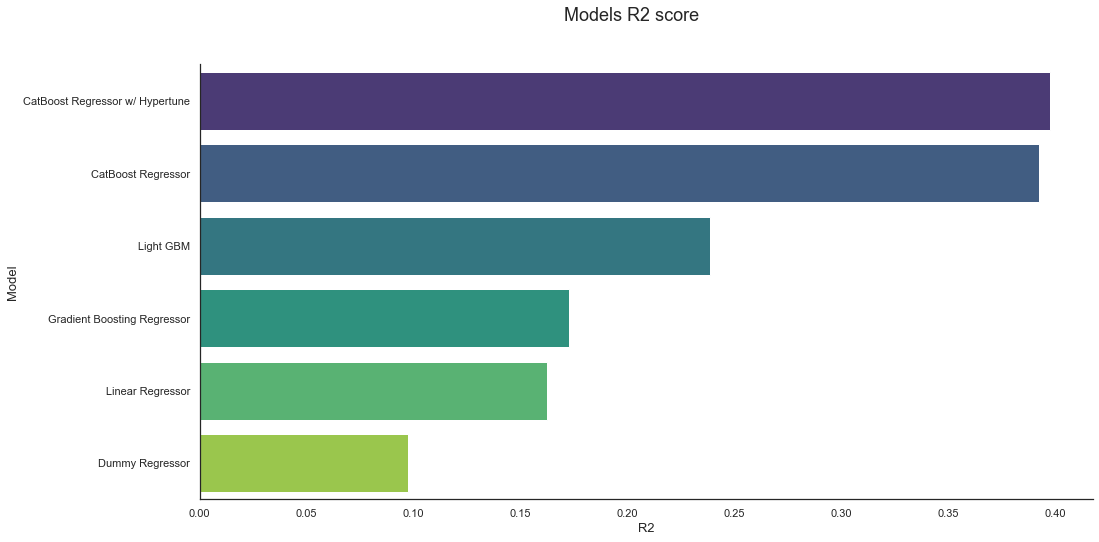

In [199]:
fig, ax = plt.subplots(figsize=(16,8))
sns.set_palette("viridis", len(R2))
# rank = forcasted_sort.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
sns.barplot(x='R2', y='Model', data = R2.sort_values('R2',ascending=False))
sns.despine()
fig.suptitle("Models R2 score", fontsize = 18)
ax.set_xlabel("R2", fontsize = 13)
ax.set_ylabel("Model", fontsize = 13)
plt.savefig('../figures/r2.png', transparent=True,bbox_inches="tight", dpi=500)
plt.savefig('../figures/r2.jpeg', transparent=True,bbox_inches="tight", dpi=500)

We can see from the above plot that our best model is our CatBoost Regressor with Hypertuned parameters. Our best estimator from that grid search is with the following parameters:

```
{'catboost__depth': 10,
 'catboost__learning_rate': 0.1,
 'catboost__min_data_in_leaf': 10,
 'catboost__n_estimators': 100}
 
```

### Prediction with Best Model

Let's use our best model to predict our test data and find the RMSE.

In [157]:
y_pred = catboost_grid_model.best_estimator_.predict(X_test)

rmse = mean_squared_error(y_test,y_pred,squared=False)

rmse

6.577646870173051

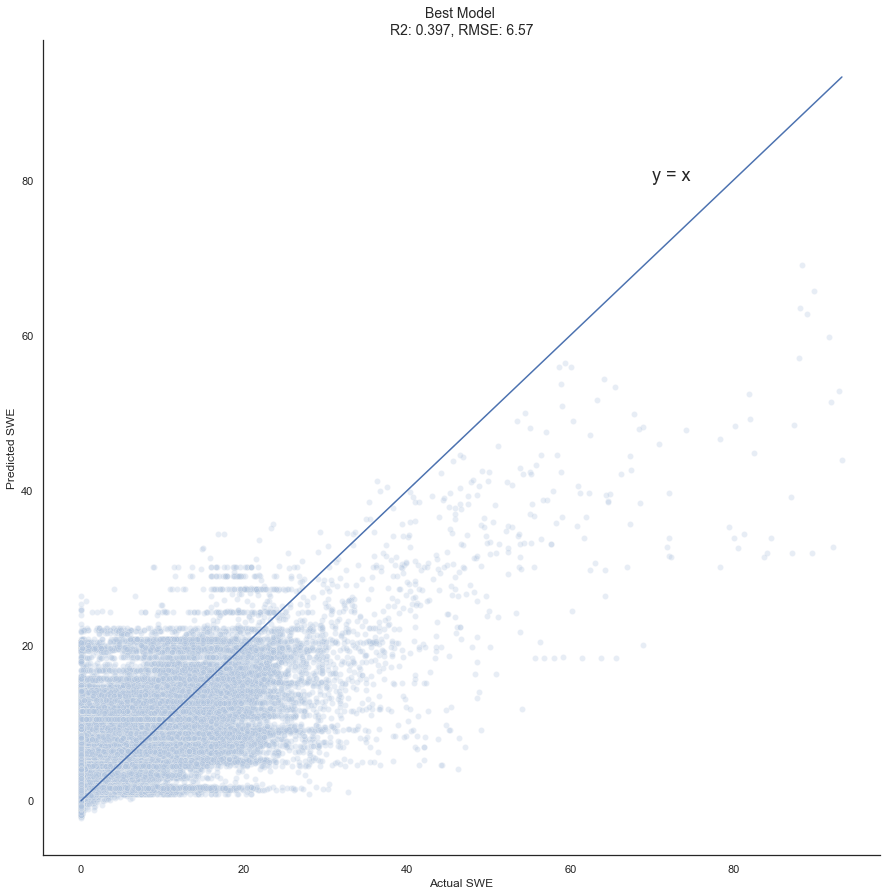

In [190]:
#Plot average prediction error
fig, ax = plt.subplots (1,1,figsize = (15,15))

sns.set_theme(style = 'white')

ax1 = sns.scatterplot(x=y_test, y=y_pred, ax = ax, color = 'lightsteelblue', alpha = 0.3)
sns.lineplot(x=y_test, y=y_test, ax = ax)

x_label = 'Actual SWE'
y_label = 'Predicted SWE'


ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)

ax1.set_title('Best Model \nR2: 0.397, RMSE: 6.57',fontsize = 14)
ax1.annotate('y = x', xy =(70,80), fontsize = 18)


sns.despine()

plt.savefig('../figures/model_performance.jpeg',bbox_inches="tight",dpi=500)

The blue lines represent if our model perfectly predicted the SWE and the scatter points represent Predicted SWE vs Actual SWE. We see that our model isn't able to predict our SWE very well and to reiterate, this is primarily due to the lack of features that are directly describing the environment of the grid cells. And this is important since Snow Water formation is highly influenced by regional climate (temperature, precipitation etc.) and geospatial information (i.e. elevation, vegetation).

## Feature Importance

Let's get feature importance from our best model.

In [186]:
#Get feature importance values
feature_values = list(catboost_grid_model.best_estimator_.named_steps["catboost"].feature_importances_)

#Build list of column names after Column Transformation
feature_names = ['PC1','PC2','PC3']
feature_names.extend(list(X_train.columns[13:22]))
feature_names.extend(list(subpipe_cat.fit(X_train).named_steps['ohe'].get_feature_names_out()))
len(feature_names)

15

In [201]:
# Create key:value pair col_name:feature_importance
feature_imp_dict = {ft_name:ft_imp for ft_name,ft_imp in zip(feature_names,feature_values)}

#Create dataframe from dictionary of features
feature_imp_df = pd.DataFrame.from_dict(feature_imp_dict, orient = 'index').reset_index()
feature_imp_df = feature_imp_df.rename(columns={'index':'col_name',0:'feat_imp'})
#Get top 10 feature
feature_imp_df = feature_imp_df.sort_values('feat_imp',ascending = False).head(10)

#Sniff test
feature_imp_df

,col_name,feat_imp
11,longitude,31.509204
10,latitude,22.872581
3,neighbor_14,14.746022
9,neighbor_20,6.703263
8,neighbor_19,5.062632
7,neighbor_18,4.506834
6,neighbor_17,2.656348
0,PC1,2.358456
4,neighbor_15,2.300856
5,neighbor_16,2.096531


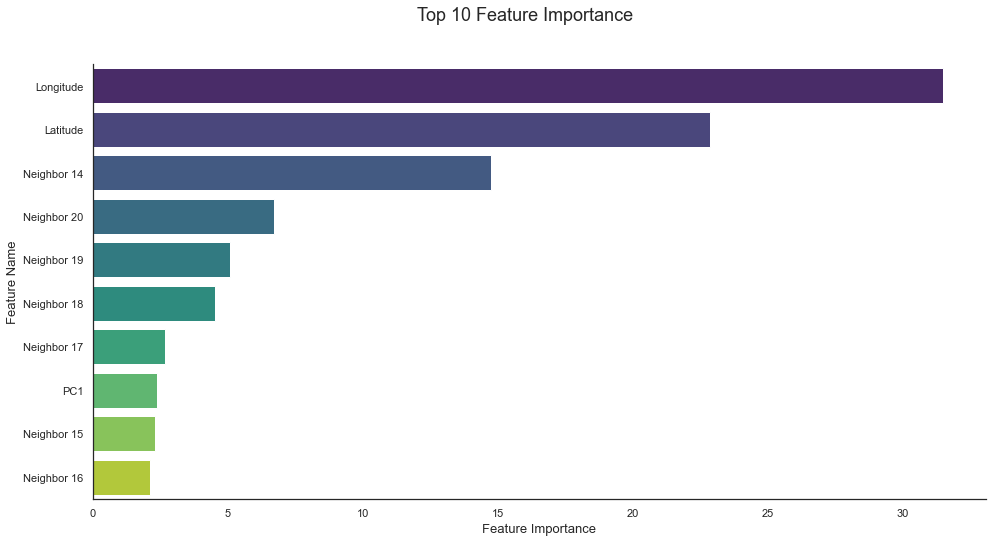

In [205]:
#Plot feature importance

fig, ax = plt.subplots(figsize=(16,8))
sns.set_palette("viridis", len(feature_imp_df))
# rank = forcasted_sort.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
g = sns.barplot(x='feat_imp', y='col_name', data = feature_imp_df,ax=ax)
g.set_yticks(range(len(feature_imp_df))) # <--- set the ticks first
g.set_yticklabels(['Longitude','Latitude','Neighbor 14','Neighbor 20','Neighbor 19',\
                   'Neighbor 18','Neighbor 17','PC1','Neighbor 15','Neighbor 16'])
sns.despine()
fig.suptitle("Top 10 Feature Importance", fontsize = 18)
ax.set_xlabel("Feature Importance", fontsize = 13)
ax.set_ylabel("Feature Name", fontsize = 13)
plt.savefig('../figures/feat_imp.png', transparent=True,bbox_inches="tight", dpi=500)
plt.savefig('../figures/feat_imp.jpeg', transparent=True,bbox_inches="tight", dpi=500)

It is no surprise that the most important features is latitude and longitude since these two features are the only features that are **direct** geospatial features of our grid cells. This further emphasizes how beneficial it would be to incorporate satellite imagery, elevation and climate data as part of our model features to improve our R2 and RMSE since the thickness of snow packs at any given time depend on these climatological and geospatial features at those grid cells.

## Conclusion

### Future Work

**1. Explore Time-Series to forecast SWE at SNOTEL and CDEC stations**

On top of predicting SWE at the location of grid cells, it would be highly valuable to conduct a time series analysis of SWE at SNOTEL and CDEC (ground measure) stations and furthermore, to be able to forecast SWE at these locations. 

**2. Exploration of feature engineering**
  
  As observed from our model performance, our model could do better with more features that are engineered. Some possibilities include:
  - Using historical mean of SWE and SWE relative to historical mean. This could possibly capture long term trends in the region. 
  - Calculate the snow day at which the observation was measured. This could help capture seasonal trends in our data.

**3. Incorporate data from satellite imageries & remote sensing data**
  - Satellite imageries (MODIS Terra/Aqua Data)
  - Climate data
  - DEM 
The model could've beneffited just from the mean and variance of pixel values over an entire grid cell for the satellite imageris (MODIS and DEM).

**4. Use near Real-time data to predict SWE**